# Import

In [3]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, box
from shapely.ops import unary_union
import matplotlib.pyplot as plt
from pyproj import Transformer
import json
import re
from unidecode import unidecode

# Prepare GPS data

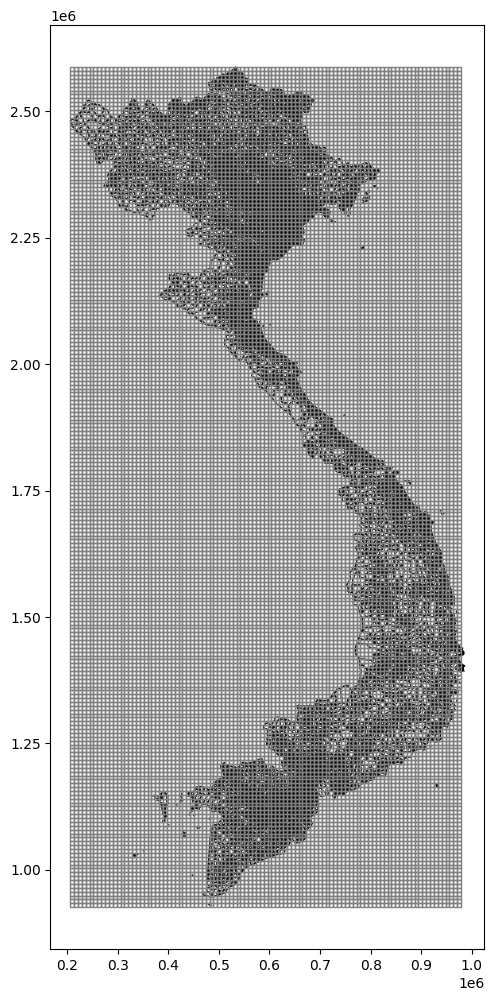

In [4]:
# Load the data from a JSON file
with open('large_files/gadm41_VNM_3.json', encoding='utf-8') as file:
    gadm = json.load(file)

# Normalize the JSON data into a pandas DataFrame
gps = pd.json_normalize(gadm['features'])

# Function to convert nested lists to MultiPolygon
def convert_to_multipolygon(nested_list):
    polygons = [Polygon(polygon[0]) for polygon in nested_list]
    return unary_union(polygons)

# Convert the 'geometry.coordinates' column to geometry
gps['geometry'] = gps['geometry.coordinates'].apply(convert_to_multipolygon)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(gps, geometry='geometry')
gdf.crs = "EPSG:4326"  # Set the coordinate reference system

# Reproject the GeoDataFrame to UTM
utm_crs = "EPSG:32648"  # UTM zone 48N for Vietnam
gdf_utm = gdf.to_crs(utm_crs)

# Get the bounds in the UTM coordinate system
bounds_utm = gdf_utm.total_bounds
minx, miny, maxx, maxy = bounds_utm

# Cell size in meters (7.65 km)
cell_size = 7650

# Calculate number of cells in x and y directions
num_cells_x = int((maxx - minx) / cell_size)
num_cells_y = int((maxy - miny) / cell_size)

# Create the grid cells
grid_cells = [box(minx + i * cell_size, miny + j * cell_size, 
                  minx + (i + 1) * cell_size, miny + (j + 1) * cell_size) 
              for i in range(num_cells_x) for j in range(num_cells_y)]

# Create a GeoDataFrame from the grid cells
grid_utm = gpd.GeoDataFrame(geometry=grid_cells)
grid_utm.crs = utm_crs

# Initialize the transformer to convert from UTM to WGS 84
transformer = Transformer.from_crs(utm_crs, "epsg:4326", always_xy=True)

# Analyze intersections and calculate centroids
results = []
for cell in grid_utm.geometry:
    centroid_utm = cell.centroid
    lon, lat = transformer.transform(centroid_utm.x, centroid_utm.y)
    intersected_wards = gdf_utm[gdf_utm.intersects(cell)]
    for idx, ward in intersected_wards.iterrows():
        intersection_area = cell.intersection(ward.geometry).area
        percent_coverage = (intersection_area / cell.area) * 100
        results.append({
            'cell_id': cell.wkt,
            'ward_id': ward['properties.GID_3'],
            'percent_coverage': percent_coverage,
            'centroid_longitude': lon,
            'centroid_latitude': lat
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plotting (optional)
fig, ax = plt.subplots(figsize=(12, 12))
gdf_utm.plot(ax=ax, color='white', edgecolor='black')
grid_utm.plot(ax=ax, facecolor="none", edgecolor='grey')
plt.show()

Cells can appear multiple time in the df. We should filter those cells that total land coverage is less 95%. (like those in the ocean)

In [5]:
# Group by cell id to find the total land coverage
total_land_coverage_by_cell = results_df.groupby(['cell_id'])['percent_coverage'].agg('sum')
cell_ids_with_large_coverage = total_land_coverage_by_cell[total_land_coverage_by_cell > 95].index.to_list()
results_df = results_df[results_df['cell_id'].isin(cell_ids_with_large_coverage)]

On average a cell contains 6.4 wards

In [6]:
unique_ward_count_by_cell = results_df.groupby('cell_id')['ward_id'].nunique()
max_unique_ward_count = unique_ward_count_by_cell.max()
cell_id_with_max_ward_count = unique_ward_count_by_cell.idxmax()

count    5224.000000
mean        6.379403
std         5.005072
min         1.000000
25%         4.000000
50%         5.000000
75%         7.000000
max       138.000000
Name: ward_id, dtype: float64

In [11]:
# Group by cell_id and count unique ward_id for each cell
unique_ward_count_by_cell = results_df.groupby('cell_id')['ward_id'].nunique()

# Find the cell_id with the maximum count of unique ward_ids
max_unique_ward_count = unique_ward_count_by_cell.max()
cell_id_with_max_ward_count = unique_ward_count_by_cell.idxmax()

In [14]:
results_df[results_df['cell_id']==cell_id_with_max_ward_count]

,cell_id,ward_id,percent_coverage,centroid_longitude,centroid_latitude
24446,"POLYGON ((688013.1598511024 1186564.686800875,...",VNM.25.1.3_1,5.241672,106.684475,10.76399
24447,"POLYGON ((688013.1598511024 1186564.686800875,...",VNM.25.3.1_1,0.222654,106.684475,10.76399
24448,"POLYGON ((688013.1598511024 1186564.686800875,...",VNM.25.3.6_1,0.401668,106.684475,10.76399
24449,"POLYGON ((688013.1598511024 1186564.686800875,...",VNM.25.3.7_1,0.845498,106.684475,10.76399
24450,"POLYGON ((688013.1598511024 1186564.686800875,...",VNM.25.3.8_1,0.651795,106.684475,10.76399
...,...,...,...,...,...
24579,"POLYGON ((688013.1598511024 1186564.686800875,...",VNM.25.22.11_1,0.522155,106.684475,10.76399
24580,"POLYGON ((688013.1598511024 1186564.686800875,...",VNM.25.22.12_1,0.981175,106.684475,10.76399
24581,"POLYGON ((688013.1598511024 1186564.686800875,...",VNM.25.22.13_1,0.829951,106.684475,10.76399
24582,"POLYGON ((688013.1598511024 1186564.686800875,...",VNM.25.22.14_1,0.628416,106.684475,10.76399


In [ ]:
results_df.to_csv('../data/ward_data.csv', index=False)

# Prepare the ward code data

In [60]:
ward_code = pd.read_csv('./large_files/district_code.csv')

def remove_administrative_terms(s):
    administrative_terms = ['Quận', 'Thành Phố', 'Huyện', 'Thị Xã', 'Tỉnh', 'Phường', 'Xã', 'Thị Trấn']
    for term in administrative_terms:
        s = re.sub(f'(?i){term}', '', s)
    return s.strip()

def merge_words(s):
    return s.replace(' ','')

dfs = []
for year in ['2016','2018','2019']:
    relevant_year = [col for col in ward_code.columns if col.endswith(year) and (col.startswith('ward') or col.startswith('distname') or col.startswith('provname'))]
    df = ward_code[relevant_year].copy()
    df.loc[:,'year'] = year
    if year == '2019':
        df.columns = ['provname','distname','id','wardname','year']
    else:
        df.columns = ['provname','distname','id','wardname','change','year']    
    dfs.append(df)

ward = pd.concat(dfs, ignore_index=True,axis=0)
ward_code = pd.concat(dfs, ignore_index=True,axis=0)
ward_code.drop_duplicates(inplace=True)
ward_code.dropna(inplace=True)

ward_code['distname'] = ward_code['distname'].apply(remove_administrative_terms)
ward_code['provname'] = ward_code['provname'].apply(remove_administrative_terms)
ward_code['wardname'] = ward_code['provname'].apply(remove_administrative_terms)

# Remove accent
ward_code['distname'] = ward_code['distname'].apply(unidecode)
ward_code['provname'] = ward_code['provname'].apply(unidecode)
ward_code['wardname'] = ward_code['wardname'].apply(unidecode)
# Remove spaces
ward_code['distname'] = ward_code['distname'].apply(merge_words)
ward_code['provname'] = ward_code['provname'].apply(merge_words)
ward_code['wardname'] = ward_code['wardname'].apply(merge_words)

C:\Users\lhmtr\AppData\Local\Temp\ipykernel_46000\3109726789.py:1: DtypeWarning: Columns (153) have mixed types. Specify dtype option on import or set low_memory=False.
  ward_code = pd.read_csv('./large_files/district_code.csv')


# Merge all data together

In [101]:
gps['properties.VARNAME_1'] = gps['properties.NAME_1'].apply(remove_administrative_terms)
gps['properties.VARNAME_1'] = gps['properties.NAME_1'].apply(unidecode)

In [102]:
merged_df = district_code.merge(gps[['properties.VARNAME_1','properties.VARNAME_2','area','centroid_lon','centroid_lat']], how='left', left_on=['provname','distname'], right_on=['properties.VARNAME_1','properties.VARNAME_2'])

In [107]:
merged_df.drop(['properties.VARNAME_1','properties.VARNAME_2'],inplace=True,axis=1)

In [108]:
merged_df.to_csv('../data/district_data.csv')